# Experiment in n-d neural SVGD

In [1]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/main/learning_particle_gradients/")
from matplotlib.animation import FuncAnimation

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd

import utils
import plot
import distributions
import models
import flows
    
key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [ ]:
# set up exporting
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

figure_path = "/home/lauro/documents/msc-thesis/thesis/figures/"
# save figures by using plt.savefig('path/to/fig')
# remember that latex textwidth is 5.4in
# so use figsize=[5.4, 4], for example
printsize = [5.4, 4]

# 50-Dimensional Gaussian with different variance scales

In [ ]:
%autoreload

In [49]:
d = 50
variances = np.logspace(-4, 0, num=d)
target = distributions.Gaussian(np.zeros(d), variances)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
setup = distributions.Setup(target, proposal)

In [97]:
n_steps = 500
particle_lr = 2e-4
# particle_lr = 5e-3
learner_lr = 1e-5 # 1e-4 is too small, I think?
n_particles = 200
key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, sizes=[32, 32, d], patience=2, learner_lr=learner_lr)
# svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, scaled=True,  bandwidth=None)
# sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr)

100%|██████████| 500/500 [06:32<00:00,  1.27it/s]


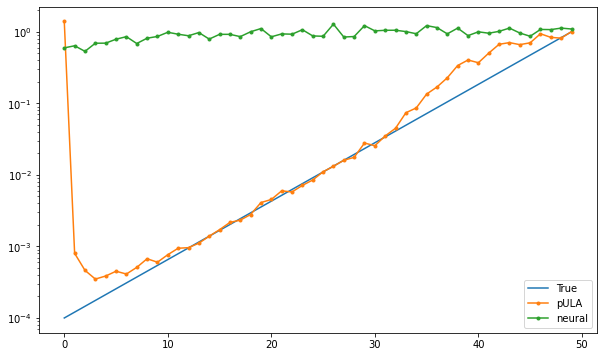

In [98]:
plt.subplots(figsize=[10, 6])

c = np.cov(sgld_particles.particles.training, rowvar=False)
nc = np.cov(neural_particles.particles.training, rowvar=False)
grid = np.arange(0, d)

plt.plot(grid, np.diag(target.cov), label="True")
plt.plot(grid, np.diag(c), label="pULA", marker=".")
plt.plot(grid, np.diag(nc), label="neural", marker=".")

plt.legend()
plt.yscale("log")

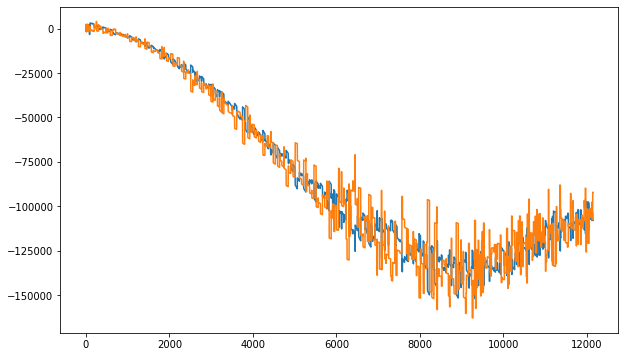

In [99]:
plt.subplots(figsize=[10, 6])

plt.plot(neural_learner.rundata["training_loss"])
plt.plot(neural_learner.rundata["validation_loss"])

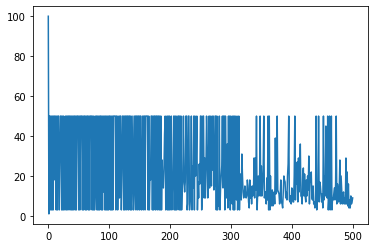

In [100]:
plt.plot(neural_learner.rundata["train_steps"])

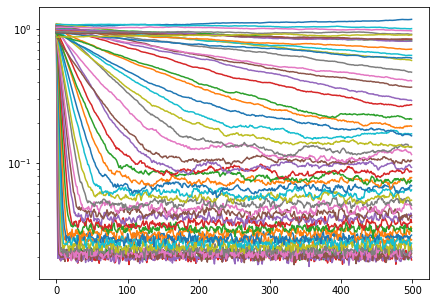

In [101]:
plt.subplots(figsize=[7, 5])
plt.plot(sgld_particles.rundata["training_std"]);
plt.yscale("log")

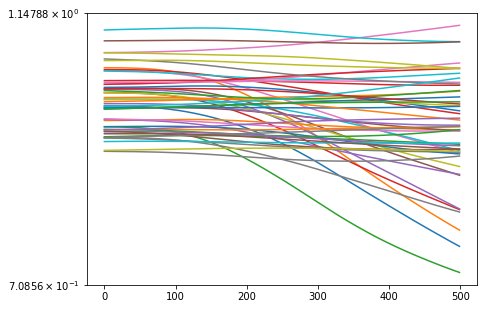

In [102]:
plt.subplots(figsize=[7, 5])
plt.plot(neural_particles.rundata["training_std"]);
plt.yscale("symlog")

In [ ]:
# get final particles
target_cov = target.cov
final_particles_list = [p.particles.training for p in (neural_particles, svgd_particles, sgld_particles)]
covs = [target.cov] + [np.cov(p, rowvar=False) for p in final_particles_list]
titles = ["True", "neural", "svgd", "pULA"]
# neural_final, svgd_final, sgld_final = final_particles_list

In [ ]:
%matplotlib inline
plt.subplots(figsize=[20, 7])
grid = np.arange(0, d)

plt.plot(grid, np.diag(target.cov), label="True")
for cov_diagonal, name in zip([np.diag(cov) for cov in covs[1:]], ["Neural", "SVGD", "pULA"]):
    plt.plot(grid, cov_diagonal, label=name, marker="o")

plt.legend()
plt.ylabel("Variance per axis")
plt.xlabel("Axis index")
plt.yscale("log")
plt.ylim((1e-4, 1.5))

In [ ]:
# fig, axs = plt.subplots(1, 4, figsize=[18, 5])
# axs = axs.flatten()
# for ax, cov, title in zip(axs, covs, titles):
#     ax.imshow(cov)
#     ax.set_title(title)

# Same thing but larger bandwidth

In [28]:
# svgd_gradient2, svgd_particles2, err2 = flows.svgd_flow(subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True, bandwidth=100)
svgd_gradient3, svgd_particles3, err3 = flows.svgd_flow(subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True, bandwidth=8)

In [29]:
all_covs = covs
all_covs.extend([np.cov(p.get_params().training, rowvar=False) for p in (svgd_particles2, svgd_particles3)])
all_names = ["Neural", "SVGD with median heuristic", "SGLD", "SVGD h = 100", "SVGD h = 10"]

## Final figure

(0.0001, 1.5)

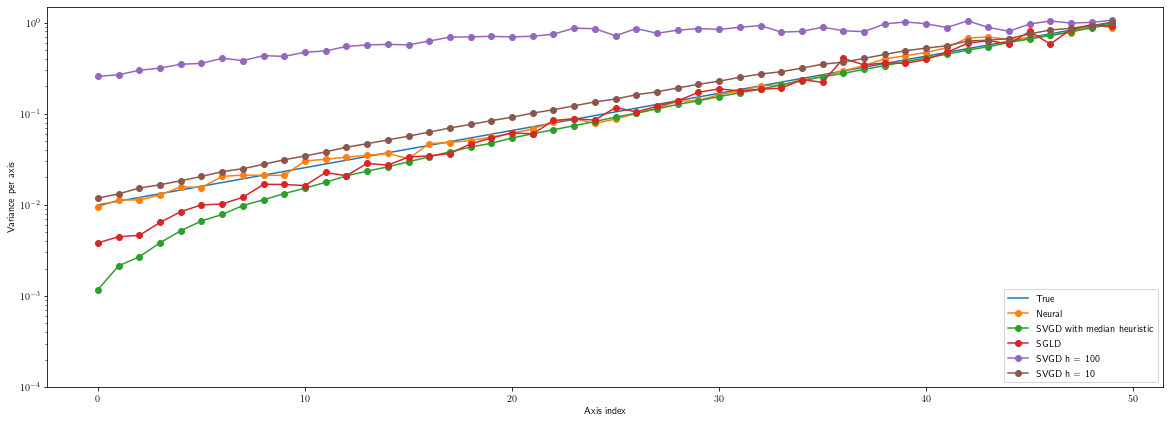

In [30]:
%matplotlib inline
plt.subplots(figsize=[20, 7])
# plt.subplots(figsize=printsize)
grid = np.arange(0, d)

plt.plot(grid, np.diag(target.cov), label="True")
for cov_diagonal, name in zip([np.diag(cov) for cov in all_covs[1:]], all_names):
    plt.plot(grid, cov_diagonal, label=name, marker="o")
# plt.plot(grid, np.diag(target.cov), label="True", color="tab:blue")

    
plt.legend()
plt.ylabel("Variance per axis")
plt.xlabel("Axis index")
plt.yscale("log")
plt.ylim((1e-4, 1.5))

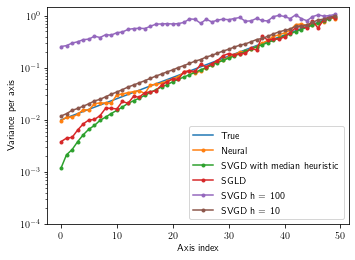

In [31]:
# plt.subplots(figsize=[20, 7])
plt.subplots(figsize=[5.4,4])
grid = np.arange(0, d)

plt.plot(grid, np.diag(target.cov), label="True")
for cov_diagonal, name in zip([np.diag(cov) for cov in all_covs[1:]], all_names):
    plt.plot(grid, cov_diagonal, label=name, marker=".")
# plt.plot(grid, np.diag(target.cov), label="True", color="tab:blue")

    
plt.legend()
plt.ylabel("Variance per axis")
plt.xlabel("Axis index")
plt.yscale("log")
plt.ylim((1e-4, 1.5))

plt.savefig(figure_path + "sampling-ill-conditioned-gaussian.pgf")

# High-dim Funnel

In [12]:
n_steps = 200
# particle_lr = 1e-2
# learner_lr = 8e-2
particle_lr = 1e-2
learner_lr = 1e-2
n_particles = 200
d = 25

In [13]:
%autoreload

In [14]:
target = distributions.Funnel(d)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
funnel_setup = distributions.Setup(target, proposal)

In [15]:
key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., sizes=[32, 32, d], patience=0, learner_lr=learner_lr)
svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=None)
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, funnel_setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)

100%|██████████| 200/200 [00:07<00:00, 26.40it/s]


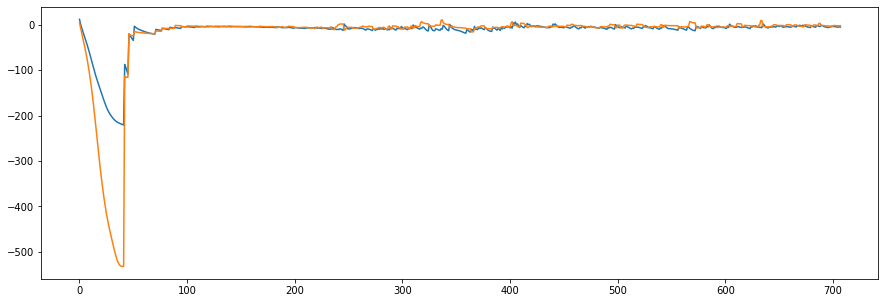

In [16]:
%matplotlib inline
plt.subplots(figsize=[15, 5])
plt.plot(neural_learner.rundata["training_loss"])
plt.plot(neural_learner.rundata["validation_loss"])

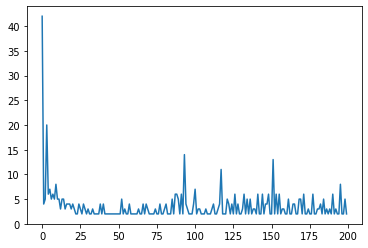

In [17]:
%matplotlib inline
plt.plot(neural_learner.rundata["train_steps"])

In [18]:
# get final particles
target_cov = target.cov
final_particles_list = []
for p in [neural_particles, svgd_particles, sgld_particles]:
    particles = p.get_params()
    final_particles_list.append(particles.training)
covs = [target.cov] + [np.cov(p, rowvar=False) for p in final_particles_list]
titles = ["True", "neural", "svgd", "sgld"]
neural_final, svgd_final, sgld_final = final_particles_list

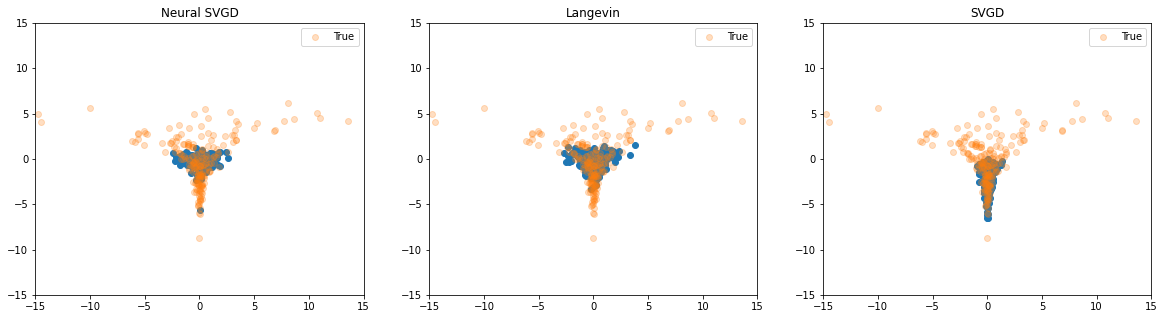

In [19]:
%matplotlib inline
lims=(-15, 15)
def plot_projection(idx):
    true_samples = target.sample(200)
    sample_list = [p.particles.training for p in (neural_particles, sgld_particles, svgd_particles)]
    fig, axs = plt.subplots(1, 3, figsize=[20, 5])
    titles = ("Neural SVGD", "Langevin", "SVGD")
    for samples, ax, title in zip(sample_list, axs.flatten(), titles):
        ax.scatter(*np.rollaxis(samples[:, idx], 1))
        ax.scatter(*np.rollaxis(true_samples[:, idx], 1), alpha=0.25, label="True")
        ax.legend()
        ax.set_title(title)
        ax.set(xlim=lims, ylim=lims)

idx = np.array([1, -1])
plot_projection(idx)

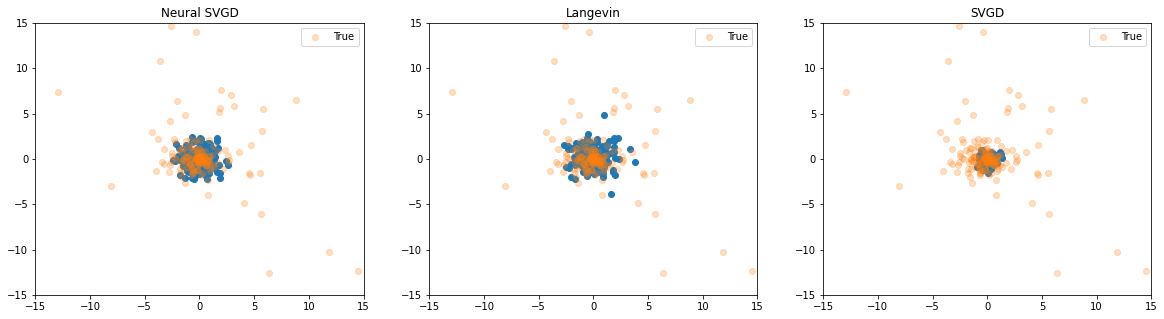

In [20]:
idx = np.array([1, 2])
plot_projection(idx)

In [21]:
# plt.plot(neural_particles.rundata["training_std"]);

### animate projection

In [22]:
idx = np.array([1, -1])

In [27]:
trajectory = neural_particles.rundata["particles"]
trajectory = np.array([t.training for t in trajectory])
trajectory_projected = trajectory[:, :, idx]


In [26]:
# %matplotlib widget
# lims = (-15, 15)
# fig, ax = plt.subplots(figsize=[8,8])
# ax.scatter(*np.rollaxis(target.sample(n_particles)[:, idx], 1), label="True", alpha=0.25)
# ax.set(xlim=lims, ylim=lims)
# plot.animate_array(trajectory_projected, fig, ax)

# Ill-condioned Gaussian II

In [84]:
d = 50
key, subkey = random.split(key)
alpha = 0.5
beta = 1
variances = random.gamma(subkey, alpha, shape=(d,)) / beta

target = distributions.Gaussian(np.zeros(d), variances)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
setup = distributions.Setup(target, proposal)

In [85]:
%matplotlib inline

(array([ 2.,  1.,  1.,  3.,  3.,  2.,  9., 13.,  6., 10.]),
 array([-3.0189817 , -2.6856954 , -2.3524091 , -2.0191228 , -1.6858367 ,
        -1.3525504 , -1.0192641 , -0.6859779 , -0.3526916 , -0.01940534,
         0.31388092], dtype=float32),
 <BarContainer object of 10 artists>)

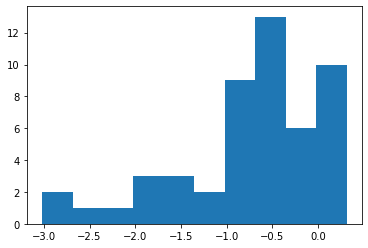

In [86]:
plt.hist(np.log10(variances))

In [107]:
n_steps = 200
particle_lr = 1e-3
learner_lr = 1e-2
n_particles = 200
# n_particles = 600
key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0, sizes=[32, 32, d], patience=2, learner_lr=learner_lr)
svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=None)
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)

100%|██████████| 200/200 [00:01<00:00, 138.37it/s]


In [108]:
var = np.diag(target.cov)

spar = sgld_particles.get_params().training
svar = np.diag(np.cov(spar, rowvar=False))

npar = neural_particles.get_params().training
nvar = np.diag(np.cov(npar, rowvar=False))

stpar = svgd_particles.get_params().training
stvar = np.diag(np.cov(stpar, rowvar=False))

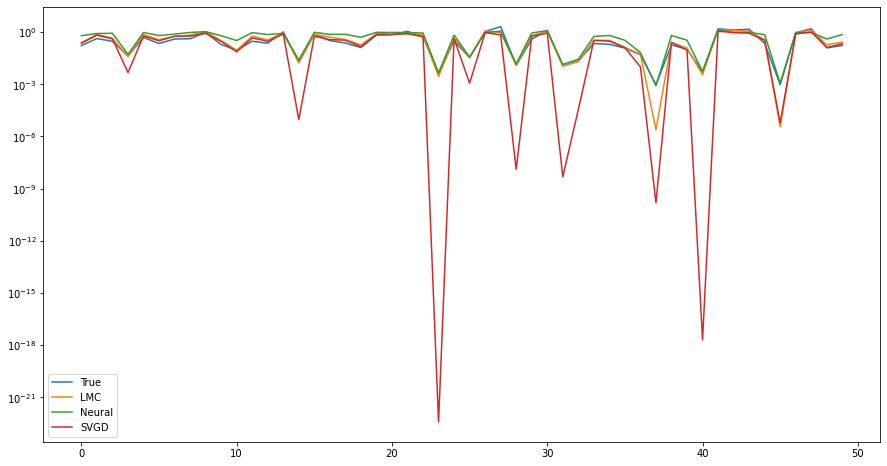

In [109]:
plt.subplots(figsize=[15, 8])
plt.plot(tvar, label="True")
plt.plot(svar, label="LMC")
plt.plot(nvar, label="Neural")
plt.plot(stvar, label="SVGD")
plt.yscale("log")
plt.legend()

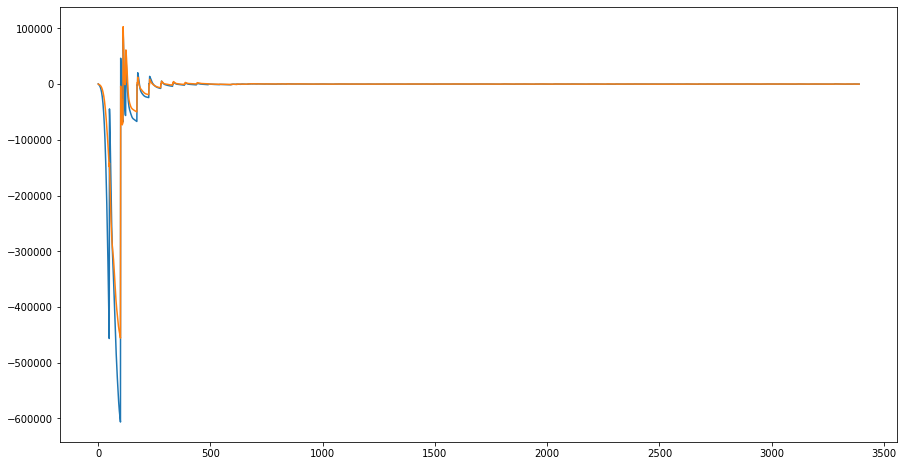

In [110]:
# %matplotlib widget
plt.subplots(figsize=[15, 8])
plt.plot(neural_learner.rundata["training_loss"])
plt.plot(neural_learner.rundata["validation_loss"])

In [111]:
# get final particles
target_cov = target.cov
final_particles_list = []
for p in [neural_particles, svgd_particles, sgld_particles]:
    particles = p.get_params()
    final_particles_list.append(particles.training)
covs = [target.cov] + [np.cov(p, rowvar=False) for p in final_particles_list]
titles = ["True", "neural", "svgd", "sgld"]
# neural_final, svgd_final, sgld_final = final_particles_list

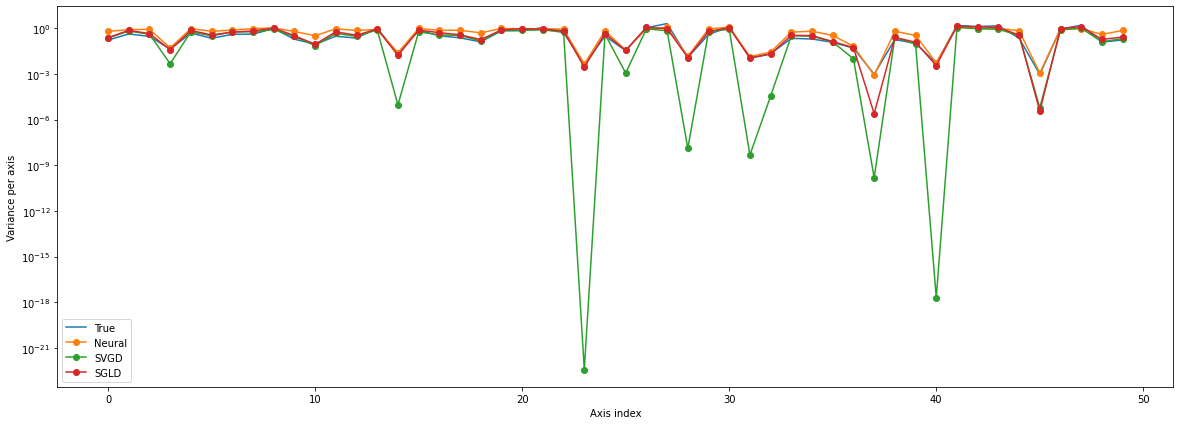

In [112]:
%matplotlib inline
plt.subplots(figsize=[20, 7])
grid = np.arange(0, d)

plt.plot(grid, np.diag(target.cov), label="True")
for cov_diagonal, name in zip([np.diag(cov) for cov in covs[1:]], ["Neural", "SVGD", "SGLD"]):
    plt.plot(grid, cov_diagonal, label=name, marker="o")

plt.legend()
plt.ylabel("Variance per axis")
plt.xlabel("Axis index")
plt.yscale("log")
# plt.ylim((variances.min() / 10, variances.max()*10))

In [113]:
neural_learner.rundata.keys()

dict_keys(['train_steps', 'gradient_norms', 'l2_norm', 'mean_drift', 'mean_repulsion', 'step_counter', 'training_loss', 'training_sd', 'validation_loss', 'validation_sd'])

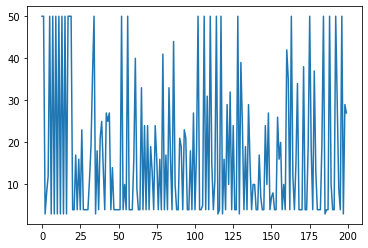

In [114]:
plt.plot(neural_learner.rundata["train_steps"])

# Rotated Gaussian

In [25]:
sdlkfj

NameError: name 'sdlkfj' is not defined

In [ ]:
# d = 50
# variances = np.logspace(-2, 0, num=d)
key, subkey = random.split(key)
Q = utils.qmult(subkey, d)


def rot(m):
    return Q.T @ m @ Q


def inv_rot(m):
    return Q @ m @ Q.T


cov = rot(np.diag(variances))
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
target = distributions.Gaussian(np.zeros(d), cov)
rotated_gaussian = distributions.Setup(target, proposal)

In [ ]:
n_steps = 3500
particle_lr = 1e-2
learner_lr = 1e-2
n_particles = 1000
key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, rotated_gaussian, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., sizes=[32, 32, d], patience=0, learner_lr=learner_lr)
svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, rotated_gaussian, n_particles=100,         n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=10)
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, rotated_gaussian, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)

In [ ]:
# get final particles
target_cov = target.cov
final_particles_list = []
for p in [neural_particles, svgd_particles, sgld_particles]:
    particles = p.get_params()
    final_particles_list.append(particles.training)
covs = [target.cov] + [np.cov(p, rowvar=False) for p in final_particles_list]
titles = ["True", "neural", "svgd", "sgld"]
neural_final, svgd_final, sgld_final = final_particles_list

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=[18, 5])
axs = axs.flatten()
for ax, cov, title in zip(axs, covs, titles):
    ax.imshow(cov)
    ax.set_title(title)

In [ ]:
%matplotlib inline
plt.subplots(figsize=[20, 7])
num=3
grid = np.arange(0, d)

plt.plot(grid, np.diag(inv_rot(target.cov)), label="True")
for cov_diagonal, name, i in zip([np.diag(inv_rot(cov)) for cov in covs[1:]], ["Neural", "SVGD", "SGLD"], range(3)):
    plt.plot(grid, cov_diagonal, label=name, marker="o")

plt.legend()
plt.ylabel("Variance per axis")
plt.xlabel("Axis index")
plt.yscale("log")
plt.ylim((1e-4, 1.5))

# High-dim Mixture

In [ ]:
skdfjsdk

In [ ]:
# sample m points from the corners of d-simplex
d = 3
m = 3 # =< d
idx = random.choice(key, d, (m,), replace=False)
means = np.eye(d)[idx] * 5

target = distributions.GaussianMixture(means, 1, np.ones(m))
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
setup = distributions.Setup(target, proposal)

In [ ]:
%autoreload

In [ ]:
n_steps = 500
noise = 0.
particle_lr = 1e-2
learner_lr = 1e-2
n_particles = 1000
key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_svgd_flow(subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=noise, sizes=[32, 32, d], patience=0, learner_lr=learner_lr)
svgd_gradient, svgd_particles, err2    = flows.svgd_flow(       subkey, setup, n_particles=100, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=None)
sgld_gradient, sgld_particles, err3    = flows.sgld_flow(       subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)

In [ ]:
# get final particles
target_cov = target.cov
final_particles_list = []
for p in [neural_particles, svgd_particles, sgld_particles]:
    particles = p.get_params()
    final_particles_list.append(particles.training)
covs = [target.cov] + [np.cov(p, rowvar=False) for p in final_particles_list]
titles = ["True", "neural", "svgd", "sgld"]
neural_final, svgd_final, sgld_final = final_particles_list

true_samples = target.sample(1000)

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=[13, 13])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*np.rollaxis(neural_final, 1))
ax.scatter(*np.rollaxis(sgld_final, 1))
ax.scatter(*np.rollaxis(target.means, 1), s=4000, color="red")

## Rundata high dim mixture

#### trajectory

In [ ]:
neural_trajectory = np.array(neural_particles.rundata["particles"])
sgld_trajectory = np.array(sgld_particles.rundata["particles"])

neural_trajectory_sliced = neural_trajectory[:, :200, slice_idx]

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=[10, 10])
_ = plt.plot(sgld_trajectory[:, :, 0])

In [ ]:
%matplotlib inline
plt.subplots(figsize=[20, 6])
plt.plot(neural_learner.rundata["training_loss"], "--.", label="Trainging Loss")
plt.plot(neural_learner.rundata["validation_loss"], "--.", label="Validation Loss")
# plt.plot(neural_learner.rundata["test_loss"], "--.", label="Test Loss")
# plt.ylim(0., 1e35)
plt.legend()
plt.yscale("log")

# OLD

In [ ]:
# fig, axs = plt.subplots(1, 4, figsize=[18, 5])
# axs = axs.flatten()
# for ax, cov, title in zip(axs, covs, titles):
#     ax.imshow(undo_rot(cov))
#     ax.set_title(title)

In [ ]:
%matplotlib inline
plt.subplots(figsize=[20, 7])
num=3
grid = np.arange(0, d*num, step=num)

for cov_diagonal, name, i in zip([np.diag(undo_rot(cov)) for cov in covs[1:]], ["Neural", "SVGD", "SGLD"], range(3)):
    plt.bar(grid+i, cov_diagonal, alpha=0.5, label=name)

plt.scatter(grid, np.diag(undo_rot(target.cov)), marker="_", label="True")
plt.legend()
plt.yscale("log")

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=[18, 5])
axs = axs.flatten()
for ax, cov, title in zip(axs, covs, titles):
    ax.imshow(cov)
    ax.set_title(title)

In [ ]:
# %matplotlib inline
# fig, ax = plt.subplots(figsize=[15, 25])
# # plt.ylim((0, 5))
# stdneur = np.array(neural_particles.rundata["training_std"])
# # stdsvgd = svgd_particles.rundata["training_std"]
# # stdsgld = sgld_particles.rundata["training_std"]


# # plt.plot(onp.mean(neural_particles.rundata["validation_std"], axis=1), color="blue", label="Neural Score Matching: Validation particles")
# plt.plot(stdneur, color="tab:blue", label="Neural Score Matching")
# # plt.plot(stdsvgd, color="tab:orange", label="SVGD")
# # plt.plot(stdsgld, color="tab:green", label="SGLD")

# [plt.axhline(y=y, color="black", linestyle="--") for y in np.sqrt(variances)]

# plt.ylabel("Standard Deviation")
# plt.xlabel("Step")

# plt.legend()
# # plt.yscale("log")

## plot learned gradient (projection)

In [ ]:
slice_idx = [0, 9]

In [ ]:
particles, _ = neural_particles.get_params(split_by_group=True)
# _, particles = neural_particles.get_params(split_by_group=True)
# x0 = particles[0]
x0 = np.zeros(d)

def sliced_grads(xs):
    """function (n, 2) to (n, 2)"""
    n = len(xs)
    x0s = np.tile(x0, (n, 1)) # shape (n, d)
    xs_nd = index_update(x0s, index[:, slice_idx], xs)
    vec_nd = neural_learner.grads(xs_nd)
    return vec_nd[:, slice_idx]

sliced_target = distributions.Gaussian([0, 0], variances[slice_idx])
approx_q = distributions.Gaussian(np.mean(particles, axis=0)[slice_idx], np.var(particles, axis=0)[slice_idx])
sliced_grads_true = vmap(grad(lambda x: sliced_target.logpdf(x) - approx_q.logpdf(x)))

sliced_particles = particles[:, slice_idx] 

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize=[22, 10])
axs = axs.flatten()
# lims=(-1/4, 1/4)
lims=(-11, 11)
# lims = utils.get_particle_lims(particles[:, slice_idx])
true_samples = target.sample(1000)
for ax, grad_fn in zip(axs, [sliced_grads, sliced_grads_true]):
    ax.set(xlim=lims, ylim=lims)
#     plot.plot_fun_2d(sliced_target.pdf, lims=lims, ax=ax, alpha=0.5)
    plot.plot_gradient_field(grad_fn, ax, lims=lims)
    plot.scatter(sliced_particles, ax=ax)
    plot.scatter(true_samples[:, slice_idx], ax=ax)

# animation

In [ ]:
%matplotlib inline
# fig, ax = plt.subplots(figsize=[10, 10])
# _ = plt.plot(neural_trajectory[:, :, 9])

In [ ]:
neural_trajectory_sliced.shape

In [ ]:
np.var(neural_trajectory[800], axis=0)[slice_idx]

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(figsize=[10, 10])
lim=(-11, 11)
# lim=utils.get_particle_lims(sliced_particles)
ax.set(xlim=lim, ylim=lim)
# plot.plot_fun_2d(sliced_target.pdf, lims=lim, ax=ax, alpha=0.5)
plot.animate_array(neural_trajectory_sliced, fig, ax, interval=100)

# Loss

In [ ]:
%matplotlib inline
plt.subplots(figsize=[20, 6])
plt.plot(neural_learner.rundata["training_loss"], "--.", label="Trainging Loss")
plt.plot(neural_learner.rundata["validation_loss"], "--.", label="Validation Loss")
# plt.plot(neural_learner.rundata["test_loss"], "--.", label="Test Loss")
# plt.ylim(-100, 100)
plt.legend()

## metrics

In [ ]:
psvgd, *_ = svgd_particles.get_params(split_by_group=True)
metrics.compute_final_metrics(psvgd, target)

In [ ]:
p, *_ = neural_particles.get_params(split_by_group=True)
metrics.compute_final_metrics(p[:100], target)

In [ ]:
p, *_ = sgld_particles.get_params(split_by_group=True)
metrics.compute_final_metrics(p[:100], target)